imports

In [2]:
import tensorflow as tf
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


2024-10-18 10:56:41.693815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Helper and preprocessing functions

In [3]:
def tf_scale_imgs(imgs, scale_factor):
    return imgs * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(imgs.shape)


def tf_scale_labels(labels, scale_factor):
    return labels * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(labels.shape)


def tf_f_inv(x, act_fn):
    """ (activation_size, batch_size) """
    if act_fn == "LINEAR":
        m = x
    elif act_fn == "TANH":
        num = tf.ones_like(x) + x
        div = tf.ones_like(x) - x + 1e-7
        m = 0.5 * tf.math.log(num / div)
    elif act_fn == "LOGSIG":
        div = tf.ones_like(x) - x + 1e-7
        m = tf.math.log((x / div) + 1e-7)
    else:
        raise ValueError(f"{act_fn} not supported")
    return m


def img_preproc(x, y, dtype=tf.float32): # add: tf.image.resize(image, [28,28])
  """Cast input image to a certain tf dtype and normalize them between 0 and 1."""
  x = tf.cast(x, dtype) / 255.
  #x = tf_scale_imgs(x, cf.img_scale)
  #y = tf_scale_labels(y, cf.label_scale)
  #x = tf_f_inv(x, "TANH")
  #y = tf.one_hot(y, depth=10)
  return x, y


def flatten(x, y): # adapt 
  #flattens a video image series (or batch of images) to (n_batch, n_steps, 1) d.
  shape = tf.shape(x)
  if len(shape) == 5: # hack, determining if it's a video or not (batch_size, n_steps, height, width, channels)
    x = tf.reshape(x, [shape[0], shape[1], -1])
  elif len(shape) == 4: # regular image (batch_size, height, width, channels)
    x = tf.reshape(x, [shape[0], -1])
  return x, y


In [4]:
resultspath = '/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_{epoch:02d}_{accuracy:.2f}.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= resultspath,  
    monitor='accuracy',         # The metric to monitor for saving (e.g., 'val_loss', 'val_accuracy')
    save_best_only=True,        # Save only the best model 
    save_weights_only=False,    # False = Save the entire model; True = only save weights
    mode='max',                 # Set to 'min' for metrics like loss and 'max' for metrics like accuracy
    save_freq='epoch',          # Frequency of saving, e.g., epoch or batch 
    verbose=1                   # Print when saving a model
)


build the network

In [5]:

class CustomDense(tf.keras.layers.Dense):
    def call(self, inputs):
        """This works like a dense, except for the activation being called earlier."""
        # Apply the activation to the input first
        activated_input = self.activation(inputs)
        # Perform the matrix multiplication and add the bias
        output = tf.matmul(activated_input, self.kernel)
        if self.use_bias:
            output = output + self.bias
        return output


class PredictiveCodingNetwork(tf.keras.Sequential):
    def __init__(self, layers, vars, beta, **kwargs):
        """Initialize a PredictiveCodingNetwork"""
        super().__init__(layers, **kwargs)
        self.vars = tf.convert_to_tensor(vars, dtype=tf.float32)
        self.beta = beta

    def call_with_states(self, x):
        """Note: while model call, call with states and model evaluate take
        2D input, train_step and infer take stacked 3D inputs."""
        x_list = [x]
        for layer in self.layers:
            x = layer(x)
            x_list.append(x)
        return x_list

    def train_step(self, data):
        """Note: while model call, call with states and model evaluate take
        2D input, train_step and infer take stacked 3D inputs."""
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        # do the stuff we do in train_epochs
        outputs, errors = self.infer(x, y)
        self.update_params(outputs, errors)

        # Update metrics (includes the metric that tracks the loss)
        pred = self.call(x)
        for metric in self.metrics:
            metric.update_state(y[:, -1], pred[:, -1])
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
   
    def infer(self, x_batch, y_batch=None, return_sequence=False):
        """Note: while model call, call with states and model evaluate take
        2D input, train_step and infer take stacked 3D inputs."""
        if return_sequence:
            errors_time = []
            states_time = []
        errors = [None for _ in range(len(self.layers))]
        f_x_arr = [None for _ in range(len(self.layers))]
        f_x_deriv_arr = [None for _ in range(len(self.layers))]
        shape = x_batch.shape
        batch_size, n_steps = shape[0], shape[1]

        for itr in range(n_steps):
            #print("BATCH SHAPE: ", x_batch.shape)
            # always update the current forward call
            x_forward_cur = self.call_with_states(x_batch[:, itr])
            if y_batch is not None:
                x_forward_cur[-1] = y_batch[:, itr]
            # if its the first itr, set x to the current forward call
            if itr == 0:
                x = x_forward_cur
            if itr != 0:
                # update g and x only for consecutive iterations
                for l in range(1, len(self.layers)):
                    g = tf.multiply(tf.matmul(errors[l], self.layers[l].kernel, transpose_b=True), f_x_deriv_arr[l])
                    x[l] = x[l] + (x_forward_cur[l] - x_forward_prev[l]) + self.beta * (-errors[l-1] + g)
            # update f_x etc for every iteration
            for l in range(len(self.layers)):
                f_x = self.layers[l].activation(x[l])
                f_x_deriv_fn = self.get_activation_derivative(self.layers[l].activation)
                f_x_deriv = f_x_deriv_fn(x[l])
                f_x_arr[l] = f_x
                f_x_deriv_arr[l] = f_x_deriv
                errors[l] = (x[l + 1] - tf.matmul(f_x, self.layers[l].kernel) - self.layers[l].bias) / self.vars[l]
            # fill the old forward pass with the current forward pass
            x_forward_prev = x_forward_cur
            
            if return_sequence:
                errors_time.append(errors)
                states_time.append(x)
        if return_sequence:
            states_time = [tf.stack(tensors, axis=1) for tensors in zip(*states_time)]
            errors_time = [tf.stack(tensors, axis=1) for tensors in zip(*errors_time)]
            return states_time, errors_time
        else:
            return x, errors
    
    
    def call(self, inputs, training=False):
        """Call, but time distributed."""
        x, errors = self.infer(inputs, return_sequence=True)
        return x[-1]

    def update_params(self, x, errors):
        """Update the model parameters."""
        batch_size = tf.cast(tf.shape(x[0])[0], tf.float32)
        gradients = []
        for l, layer in enumerate(self.layers):
            grad_w = self.vars[-1] * (1 / batch_size) * tf.matmul(tf.transpose(self.layers[l].activation(x[l])), errors[l])
            grad_b = self.vars[-1] * (1 / batch_size) * tf.reduce_sum(errors[l], axis=0)
            gradients.append((-grad_w, layer.kernel))
            gradients.append((-grad_b, layer.bias))
        self.optimizer.apply_gradients(gradients)

    def get_activation_derivative(self, activation):
        """Return a function for the derivative of the given activation function."""
        activation_fn = tf.keras.activations.get(activation)
        if activation_fn == tf.keras.activations.linear:
            return lambda x: tf.ones_like(x)
        elif activation_fn == tf.keras.activations.tanh:
            return lambda x: 1 - tf.square(tf.nn.tanh(x))
        elif activation_fn == tf.keras.activations.sigmoid:
            return lambda x: tf.nn.sigmoid(x) * (1 - tf.nn.sigmoid(x))
        else:
            raise ValueError(f"{activation} not supported")


Load the data

In [6]:
# Image paths 

img_dir_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Leading/'
img_dir_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Trailing/'
img_dir_test_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Leading/'
img_dir_test_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Trailing/'
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = None # adjust if needed, e.g., 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [5]:
# Image paths 

img_dir_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Leading/'
img_dir_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Trailing/' 
img_dir_test_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Leading/' 
img_dir_test_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Trailing/' 
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [7]:
# Create a dict that assigns the correct labels for each leading-trailing img pair

"""
L1 = barn = label 0 
L2 = beach = label 1
L3 = library = label 3
L4 = restaurant = label 4 
L5 = cave = label 2

T6 = Church = label 1   
T7 = conference room = label 2
T8 = castle = label 0   
T9 = forest = label 3

MAPPING:

L1 -> T6 = 0.75 -> (0,1) 
L1 -> T7 = 0.25 -> (0,2)
L1 -> T8 = 0 -> (0,0)
L1 -> T9 = 0 -> (0,3)

L2 -> T6 = 0.75 -> (1,1) 
L2 -> T7 = 0.25 -> (1,2)
L2 -> T8 = 0 -> (1,0)
L2 -> T9 = 0 -> (1,3)

L3 -> T6 = 0 -> (3,1) 
L3 -> T7 = 0 -> (3,2)
L3 -> T8 = 0.5 -> (3,0)
L3 -> T9 = 0.5 -> (3,3)

L4 -> T6 = 0.25 -> (4,1) 
L4 -> T7 = 0.75 -> (4,2)
L4 -> T8 = 0 -> (4,0)
L4 -> T9 = 0 -> (4,3)

L5 -> T6 = 0.25 -> (2,1) 
L5 -> T7 = 0.75 -> (2,2)
L5 -> T8 = 0 -> (2,0)
L5 -> T9 = 0 -> (2,3)

"""


# Sham task 
label_dict = {
    (0, 1): 1.,
    (0, 2): 1.,
    (0, 0): 1.,
    (0, 3): 1.,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 0.,
    (1, 3): 0.,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 0.,
    (3, 3): 0.,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 0.,
    (4, 3): 0.,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 0.,
    (2, 3): 0.
}

# Experimental task
label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 0): 0.25,
    (0, 3): 0.75,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 0.25,
    (1, 3): 0.75,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 0.25,
    (3, 3): 0.75,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.75,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 0.5,
    (2, 3): 0.5
}




def imgsequence(img_t1, img_t2, label_t1, label_t2, label_dict):  # adapt: 50 due to error iterations, experimental 
    """This function stacks images and prepares labels accordingly."""
    
    
    img_t1 = tf.cast(img_t1, dtype=tf.float32)
    img_t2 = tf.cast(img_t2, dtype=tf.float32)
    
    # stack imgs from both datatsets into a sequence of 4 img
    x = tf.stack([img_t1, img_t1, img_t2, img_t2], axis = 0)
    #print("Shape of x after stacking:", x.shape)

    
    key_t1 = int(label_t1.numpy())
    key_t2 = int(label_t2.numpy())
   # print("Current label pair:", (key_t1, key_t2))
   
    # Check if the key exists
    if (key_t1, key_t2) in label_dict:
       label_value = label_dict[(key_t1, key_t2)]
        #print(f"Label value found: {label_value}")
    else:
        print(f"Label pair {(key_t1, key_t2)} not found, defaulting to 0")
        label_value = 0  
    
    # Generate the label sequence 
    y_sequence = [[label_value], [label_value], [label_value], [label_value]]
    y = tf.convert_to_tensor(y_sequence, dtype=tf.float32)  # Shape (4, 1)

    #print("Generated labels (y):", y.numpy())
    #print("Shape of y:", y.shape)

    return x, y
 


In [20]:
def generate_dataset(img_dirt1, img_dirt2, class_namest1, class_namest2, label_dict, image_size = None, seed = None):       
    
    tf.random.set_seed(seed)
    
    data_t1 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt1, 
        label_mode = 'int',
        class_names= class_namest1,
        batch_size = None,
        color_mode = 'rgb',
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
        )

    data_t2 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt2, 
        label_mode = 'int',
        class_names= class_namest2,
        batch_size = None,
        color_mode = 'rgb', 
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
    )
    
    data_t1.shuffle(99999)
    data_t2.shuffle(99999)
    
    # iterate through shuffled leading and trailing datasets
    leading = iter(data_t1)
    trailing = iter(data_t2) 
              
    while True:
        try:
            # Retrieve single samples
            img_t1, label_t1 = next(leading)
            img_t2, label_t2 = next(trailing)
            #print("test img shapes.", img_t1.shape, img_t2.shape)
            #print("Shape of label_t1:", label_t1.shape)
            #print("Shape of label_t2:", label_t2.shape)

            # Generate x, y pairs for single samples
            x, y = imgsequence(img_t1, img_t2, label_t1, label_t2, label_dict) # batch_size, imgimg, 28, 28, 3
            #print("test x:", x.shape)
            #print("test y:", y.shape) 
            yield x, y
            
        except StopIteration:
            # Break the loop if no more samples
            break
     

In [18]:
# Build val_dataset 
n_steps = 4 # adapt to 50 
seed = 123
#batch_size = 32
val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_dataset(img_dir_test_lead, img_dir_test_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = seed),
    output_signature=(
        tf.TensorSpec(shape=(n_steps, 28, 28, 3), dtype=tf.float32),  # shape of x 2352; skip batch_size -> dataset.batch()
        tf.TensorSpec(shape=(n_steps, 1), dtype=tf.float32)  # shape of y 
    )
) 

print(val_dataset)


<_FlatMapDataset element_spec=(TensorSpec(shape=(4, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1), dtype=tf.float32, name=None))>


train the network

In [25]:
# define the model
model = PredictiveCodingNetwork([CustomDense(units=32, activation="tanh"),
                                 CustomDense(units=16, activation="tanh"),
                                 CustomDense(units=1, activation="sigmoid")],
                                vars=[1, 1, 1], # variances. This is super useless and in the code only the last variance is used
                                beta=0.1)

model.build([None, 2352]) 
model.compile(optimizer=tf.keras.optimizers.AdamW(1e-3),
              metrics= ["accuracy"],  # , [SequenceAccuracy], [frame_accuracy(i) for i in range(4)]
              loss="CategoricalCrossentropy",  # This is just a sham loss we need so model.evaluate doesn't throw an error. We don't use it.
              )

# evaluate accuracy and train model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy before training: {accuracy}")

#print("Weights before training:")
#for i, layer_weights in enumerate(model.get_weights()):
#    print(f"Layer {i} weights:\n{layer_weights}\n")

n_epochs = 25 

train_acc = []
val_acc = []
train_loss = []
val_loss = []

for i in range(n_epochs): 
    
    print(f"Epoch {i + 1}/{n_epochs}") 
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = seed),
        output_signature=(
            tf.TensorSpec(shape=(n_steps, 28, 28, 3), dtype=tf.float32),  # shape of x 
            tf.TensorSpec(shape=(n_steps, 1), dtype=tf.float32)  # shape of y 
        )
    ) 
    #for x, y in train_dataset.batch(32).map(img_preproc).map(flatten).take(1):
    #    pass
    #out = model(x)
    #print("EEEVAKUTAUIBNSANFIJASDIBG", model.evaluate(x, y))
    #print(out)
    #raise ValueError("STOP HERE")

    history = model.fit(train_dataset.shuffle(99999).batch(512).map(img_preproc).map(flatten), #  reshuffle_each_iteration=True
            validation_data=val_dataset.batch(512).map(img_preproc).map(flatten),
            callbacks=[checkpoint_callback]) 
    
    train_acc.extend(history.history['accuracy'])
    val_acc.extend(history.history['val_accuracy'])
    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])

#print("\nWeights after training:")
#for i, layer_weights in enumerate(model.get_weights()):
#    print(f"Layer {i} weights:\n{layer_weights}\n")

loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy after training: {accuracy}")



Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3722 - loss: 2.9802e-08
Accuracy before training: 0.3722222149372101
Epoch 1/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      2/Unknown 4s 376ms/step - accuracy: 0.6807 - loss: 0.1247Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: accuracy did not improve from 0.68193
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.6819 - loss: 0.1351 - val_accuracy: 0.5000 - val_loss: 2.9802e-08
Epoch 2/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      2/Unknown 3s 372ms/step - accuracy: 0.6807 - loss: 0.1617Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: accuracy did not improve from 0.68193
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - accuracy: 0.6819 - loss: 0.1610 - val_accuracy: 0.5000 - val_loss: 2.9802

2024-10-18 12:13:50.663395: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


      2/Unknown 3s 417ms/step - accuracy: 0.6807 - loss: 0.1543Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: accuracy did not improve from 0.68193
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.6819 - loss: 0.1500 - val_accuracy: 0.5000 - val_loss: 2.9802e-08
Epoch 7/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      2/Unknown 3s 351ms/step - accuracy: 0.6807 - loss: 0.1172Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: accuracy did not improve from 0.68193
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.6819 - loss: 0.1210 - val_accuracy: 0.5000 - val_loss: 2.9802e-08
Epoch 8/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      2/Unknown 3s 365ms/step - accuracy: 0.6807 - loss: 0.1445Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: accuracy did not improve from 0.68193
4/4

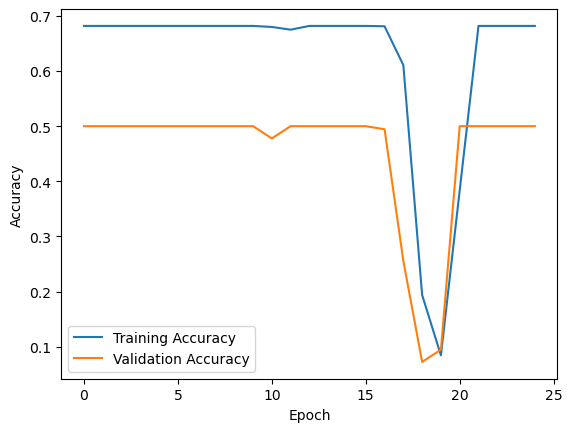

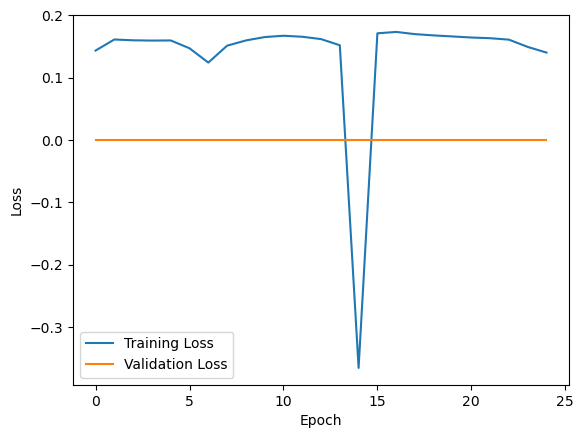

In [26]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()